In [342]:
!pip install --upgrade scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 33.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [344]:
pip install pmdarima


In [347]:
!pip install numpy

In [350]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error ,mean_absolute_error
from math import  sqrt
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
import statistics as st
from scipy.stats import mode, skew, kurtosis
import seaborn as sns

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, SimpleRNN
from keras.layers import LSTM
from keras.layers import Dropout


import pandas as pd
import joblib
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import SimpleRNN, Embedding
from tensorflow.keras.preprocessing import sequence
from keras.layers import Dense, LSTM, RNN, GRU, Dropout, Activation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import skew, kurtosis

from torch import nn
from torch.utils.data import DataLoader, Dataset
from datetime import datetime, timedelta
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

###Read data

In [283]:
eth_df = pd.read_csv("/content/Ethereum Historical Data (1).csv")
eth_df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/01/2024,"3,815.95","3,762.63","3,832.35","3,753.32",143.81K,1.42%
1,05/31/2024,"3,762.66","3,747.89","3,844.96","3,724.57",294.56K,0.40%
2,05/30/2024,"3,747.55","3,767.22","3,824.94","3,703.74",293.81K,-0.58%
3,05/29/2024,"3,769.57","3,845.56","3,886.44","3,745.72",353.25K,-1.98%
4,05/28/2024,"3,845.56","3,894.33","3,929.21","3,775.08",436.24K,-1.25%
...,...,...,...,...,...,...,...
1915,03/05/2019,136.82,125.97,141.11,125.44,16.74M,8.61%
1916,03/04/2019,125.97,131.02,131.57,123.25,14.11M,-3.85%
1917,03/03/2019,131.01,132.77,168.42,129.05,10.64M,-1.32%
1918,03/02/2019,132.76,135.72,136.36,130.74,11.29M,-2.18%


###Data processing

In [284]:
#convert to "Datetime" format
eth_df['Date'] = pd.to_datetime(eth_df['Date'])
eth_df.reset_index(drop=True)
eth_df.set_index('Date', inplace=True)
eth_df.sort_index(ascending=True, inplace=True)

In [285]:
eth_df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,135.72,135.47,138.06,128.46,9.73M,0.18%
2019-03-02,132.76,135.72,136.36,130.74,11.29M,-2.18%
2019-03-03,131.01,132.77,168.42,129.05,10.64M,-1.32%
2019-03-04,125.97,131.02,131.57,123.25,14.11M,-3.85%
2019-03-05,136.82,125.97,141.11,125.44,16.74M,8.61%
...,...,...,...,...,...,...
2024-05-28,"3,845.56","3,894.33","3,929.21","3,775.08",436.24K,-1.25%
2024-05-29,"3,769.57","3,845.56","3,886.44","3,745.72",353.25K,-1.98%
2024-05-30,"3,747.55","3,767.22","3,824.94","3,703.74",293.81K,-0.58%


In [286]:
print(eth_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2019-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     1920 non-null   object
 1   Open      1920 non-null   object
 2   High      1920 non-null   object
 3   Low       1920 non-null   object
 4   Vol.      1920 non-null   object
 5   Change %  1920 non-null   object
dtypes: object(6)
memory usage: 105.0+ KB
None


In [287]:
# Hàm để chuyển đổi giá trị có 'K', 'M', hoặc 'B' thành số thực.
def convert_volume(value):
    if 'K' in value:
        return float(value.replace('K', '')) * 1e3
    elif 'M' in value:
        return float(value.replace('M', '')) * 1e6
    elif 'B' in value:
        return float(value.replace('B', '')) * 1e9
    else:
        return float(value)

# Áp dụng hàm cho mỗi giá trị trong cột 'Vol.'.
eth_df['Vol.'] = eth_df['Vol.'].apply(convert_volume)


In [288]:
# Hàm để chuyển đổi giá trị có dấu % thành số thực.
def convert_percent_to_float(value):
    return float(value.replace('%', '')) / 100

# Giả sử etr_df là DataFrame của bạn với cột 'Percentage' cần được chuyển đổi.
# etr_df['Percentage'] = ...

# Áp dụng hàm cho mỗi giá trị trong cột 'Percentage'.
eth_df['Change %'] = eth_df['Change %'].apply(convert_percent_to_float)


In [289]:
eth_df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,135.72,135.47,138.06,128.46,9730000.0,0.0018
2019-03-02,132.76,135.72,136.36,130.74,11290000.0,-0.0218
2019-03-03,131.01,132.77,168.42,129.05,10640000.0,-0.0132
2019-03-04,125.97,131.02,131.57,123.25,14110000.0,-0.0385
2019-03-05,136.82,125.97,141.11,125.44,16740000.0,0.0861
...,...,...,...,...,...,...
2024-05-28,"3,845.56","3,894.33","3,929.21","3,775.08",436240.0,-0.0125
2024-05-29,"3,769.57","3,845.56","3,886.44","3,745.72",353250.0,-0.0198
2024-05-30,"3,747.55","3,767.22","3,824.94","3,703.74",293810.0,-0.0058


In [290]:
eth_df['Price'].dtype

dtype('O')

In [291]:
missing_values = eth_df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [292]:
eth_df['Price'] = eth_df['Price'].str.replace(',', '').astype(float)
eth_df['Open'] = eth_df['Open'].str.replace(',', '').astype(float)
eth_df['High'] =eth_df['High'].str.replace(',', '').astype(float)
eth_df['Low'] = eth_df['Low'].str.replace(',', '').astype(float)
eth_df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,135.72,135.47,138.06,128.46,9730000.0,0.0018
2019-03-02,132.76,135.72,136.36,130.74,11290000.0,-0.0218
2019-03-03,131.01,132.77,168.42,129.05,10640000.0,-0.0132
2019-03-04,125.97,131.02,131.57,123.25,14110000.0,-0.0385
2019-03-05,136.82,125.97,141.11,125.44,16740000.0,0.0861
...,...,...,...,...,...,...
2024-05-28,3845.56,3894.33,3929.21,3775.08,436240.0,-0.0125
2024-05-29,3769.57,3845.56,3886.44,3745.72,353250.0,-0.0198
2024-05-30,3747.55,3767.22,3824.94,3703.74,293810.0,-0.0058


In [293]:
eth_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,135.72,135.47,138.06,128.46,9730000.0,0.0018
2019-03-02,132.76,135.72,136.36,130.74,11290000.0,-0.0218
2019-03-03,131.01,132.77,168.42,129.05,10640000.0,-0.0132
2019-03-04,125.97,131.02,131.57,123.25,14110000.0,-0.0385
2019-03-05,136.82,125.97,141.11,125.44,16740000.0,0.0861


In [294]:

eth_df['Year'] = eth_df.index.year
eth_df['Month'] = eth_df.index.month
eth_df['Day'] = eth_df.index.day

In [295]:
eth_df


,Price,Open,High,Low,Vol.,Change %,Year,Month,Day
Date,,,,,,,,,
2019-03-01,135.72,135.47,138.06,128.46,9730000.0,0.0018,2019,3,1
2019-03-02,132.76,135.72,136.36,130.74,11290000.0,-0.0218,2019,3,2
2019-03-03,131.01,132.77,168.42,129.05,10640000.0,-0.0132,2019,3,3
2019-03-04,125.97,131.02,131.57,123.25,14110000.0,-0.0385,2019,3,4
2019-03-05,136.82,125.97,141.11,125.44,16740000.0,0.0861,2019,3,5
...,...,...,...,...,...,...,...,...,...
2024-05-28,3845.56,3894.33,3929.21,3775.08,436240.0,-0.0125,2024,5,28
2024-05-29,3769.57,3845.56,3886.44,3745.72,353250.0,-0.0198,2024,5,29
2024-05-30,3747.55,3767.22,3824.94,3703.74,293810.0,-0.0058,2024,5,30


In [296]:
eth_df.shape

(1920, 9)

###Descriptive Analysis

In [297]:
eth_df.describe()


,Price,Open,High,Low,Vol.,Change %,Year,Month,Day
count,1920.000000,1920.000000,1920.000000,1920.000000,1.920000e+03,1920.000000,1920.000000,1920.000000,1920.000000
mean,1580.443599,1578.543557,1623.758177,1529.572755,1.454516e+07,0.002749,2021.300000,6.400000,15.732292
std,1205.861719,1205.229006,1239.788033,1166.097930,1.122081e+08,0.044474,1.551479,3.413091,8.811334
min,107.900000,107.870000,117.910000,88.500000,2.703000e+04,-0.445500,2019.000000,1.000000,1.000000
25%,268.945000,268.717500,278.095000,262.277500,4.808800e+05,-0.017600,2020.000000,3.000000,8.000000
50%,1622.465000,1620.975000,1654.210000,1569.740000,1.165000e+06,0.001400,2021.000000,6.000000,16.000000
75%,2334.242500,2331.202500,2393.075000,2255.137500,8.500000e+06,0.022925,2023.000000,9.000000,23.000000
max,4808.380000,4808.340000,4864.060000,4715.430000,1.790000e+09,0.259600,2024.000000,12.000000,31.000000


In [298]:
eth_df.dtypes


Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
Year          int32
Month         int32
Day           int32
dtype: object

In [299]:
eth_df

,Price,Open,High,Low,Vol.,Change %,Year,Month,Day
Date,,,,,,,,,
2019-03-01,135.72,135.47,138.06,128.46,9730000.0,0.0018,2019,3,1
2019-03-02,132.76,135.72,136.36,130.74,11290000.0,-0.0218,2019,3,2
2019-03-03,131.01,132.77,168.42,129.05,10640000.0,-0.0132,2019,3,3
2019-03-04,125.97,131.02,131.57,123.25,14110000.0,-0.0385,2019,3,4
2019-03-05,136.82,125.97,141.11,125.44,16740000.0,0.0861,2019,3,5
...,...,...,...,...,...,...,...,...,...
2024-05-28,3845.56,3894.33,3929.21,3775.08,436240.0,-0.0125,2024,5,28
2024-05-29,3769.57,3845.56,3886.44,3745.72,353250.0,-0.0198,2024,5,29
2024-05-30,3747.55,3767.22,3824.94,3703.74,293810.0,-0.0058,2024,5,30


In [300]:
#all
print("Meadian \t")
eth_df.median()

Meadian 	


Price       1.622465e+03
Open        1.620975e+03
High        1.654210e+03
Low         1.569740e+03
Vol.        1.165000e+06
Change %    1.400000e-03
Year        2.021000e+03
Month       6.000000e+00
Day         1.600000e+01
dtype: float64

In [301]:
#all
print('Kurtosis\t')
eth_df.kurtosis()

Kurtosis	


Price        -0.726134
Open         -0.723653
High         -0.733476
Low          -0.729421
Vol.        156.849436
Change %      9.160245
Year         -1.121041
Month        -1.193897
Day          -1.194975
dtype: float64

In [302]:
#all
print('Skewness\t')
eth_df.skew()

Skewness	


Price        0.460779
Open         0.461996
High         0.462121
Low          0.454362
Vol.        12.308683
Change %    -0.341816
Year         0.054878
Month        0.072624
Day          0.006297
dtype: float64

In [303]:
# Tính toán các giá trị thống kê cột price
variance_price = st.variance(eth_df["Price"])
std_dev_price = st.stdev(eth_df["Price"])
skewness_price = skew(eth_df["Price"])
kurtosis_price = kurtosis(eth_df["Price"])
mode_price = mode(eth_df["Price"])

print("Variance:", variance_price)
print("Standard Deviation:", std_dev_price)
print("Skewness:", skewness_price)
print("Kurtosis:", kurtosis_price)
print("Mode:", mode_price)

Variance: 1454102.4859859464
Standard Deviation: 1205.861719263841
Skewness: 0.46041889940299197
Kurtosis: -0.7273679966545297
Mode: ModeResult(mode=125.24, count=2)


In [304]:
eth_df['Price'].describe()

count    1920.000000
mean     1580.443599
std      1205.861719
min       107.900000
25%       268.945000
50%      1622.465000
75%      2334.242500
max      4808.380000
Name: Price, dtype: float64

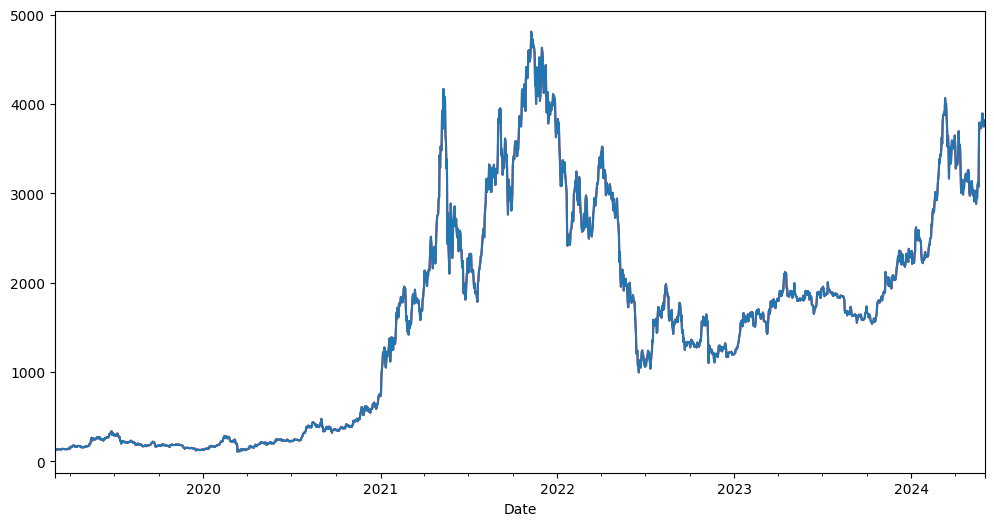

In [305]:
eth_df['Price'].plot(figsize=(12,6),color='red')

plt.plot(eth_df['Price'])

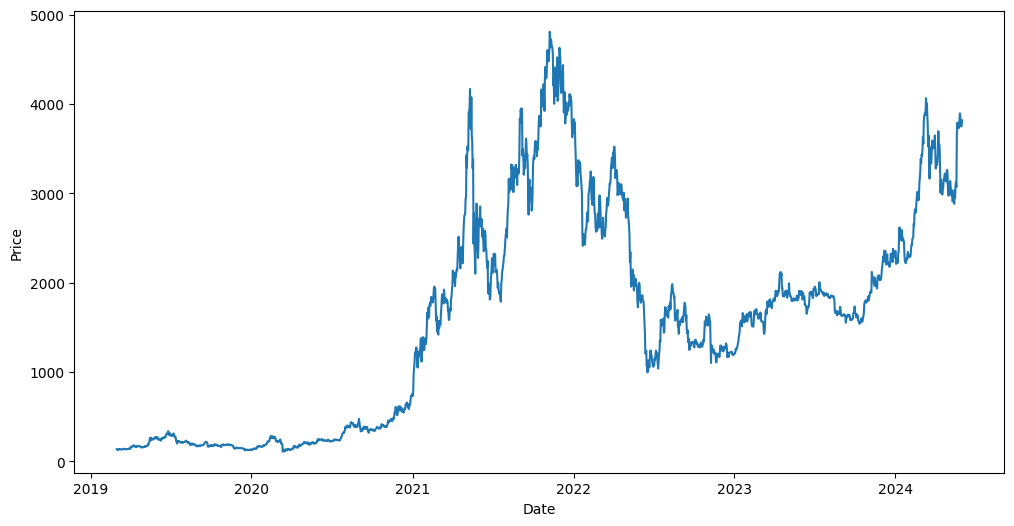

In [306]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Price', data=eth_df)

plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

<Axes: title={'center': 'Box Plot of Price'}>

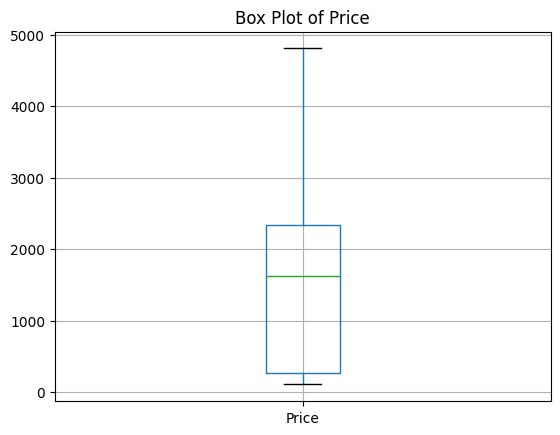

In [307]:
plt.title('Box Plot of Price')
eth_df.boxplot(column=['Price'])

<Axes: >

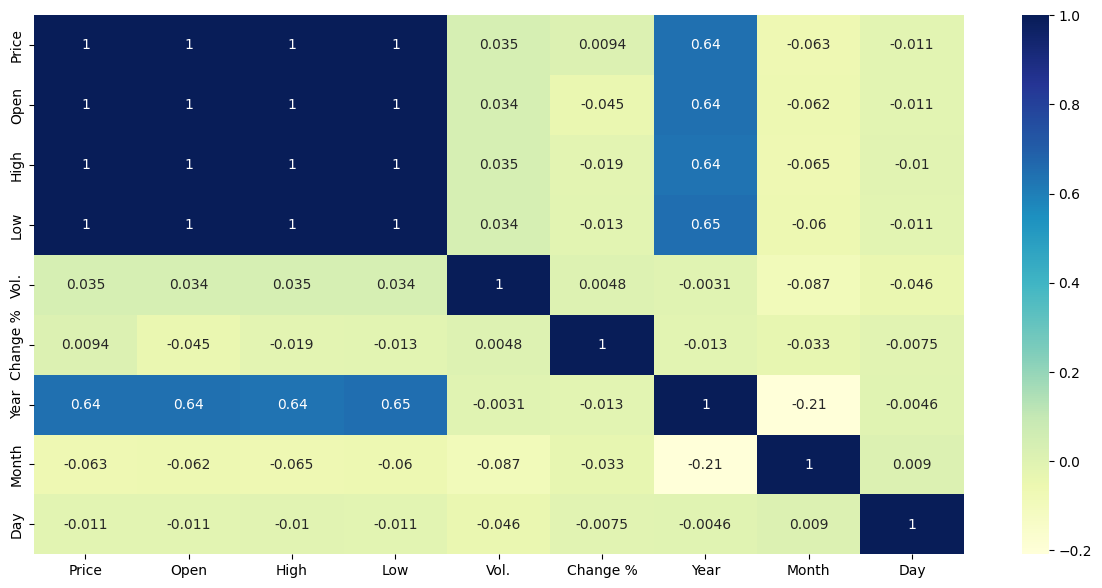

In [308]:
plt.figure(figsize=(15,7))
sns.heatmap(eth_df.corr(),annot =True,cmap="YlGnBu")

In [309]:
eth_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2019-03-01 to 2024-06-01
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1920 non-null   float64
 1   Open      1920 non-null   float64
 2   High      1920 non-null   float64
 3   Low       1920 non-null   float64
 4   Vol.      1920 non-null   float64
 5   Change %  1920 non-null   float64
 6   Year      1920 non-null   int32  
 7   Month     1920 non-null   int32  
 8   Day       1920 non-null   int32  
dtypes: float64(6), int32(3)
memory usage: 127.5 KB


###Paramater

In [310]:
window_size = 10
feature_dim = 5

train_size = 0.6
val_size = 0.1
test_size=0.3

# model params
lstm_neurons = 20
rnn_neurons = 20
epochs = 100
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

###Split data

In [311]:
eth_df.drop(columns=['Year'], inplace=True)
eth_df.drop(columns=['Month'], inplace=True)
eth_df.drop(columns=['Day'], inplace=True)


In [314]:
train_index = int(len(eth_df)*train_size)
test_index = train_index + int(len(eth_df)*test_size)

print('train index: ',train_index)
print('test index: ',test_index)

train index:  1152
test index:  1728


In [315]:
eth_df_train = eth_df.iloc[:train_index]
eth_df_test  = eth_df[train_index:test_index]
eth_df_val   = eth_df[test_index:]

print('eth_df_train.shape: ',eth_df_train.shape)
print('eth_df_test.shape: ',eth_df_test.shape)
print('eth_df_val.shape: ',eth_df_val.shape)

eth_df_train.shape:  (1152, 6)
eth_df_test.shape:  (576, 6)
eth_df_val.shape:  (192, 6)


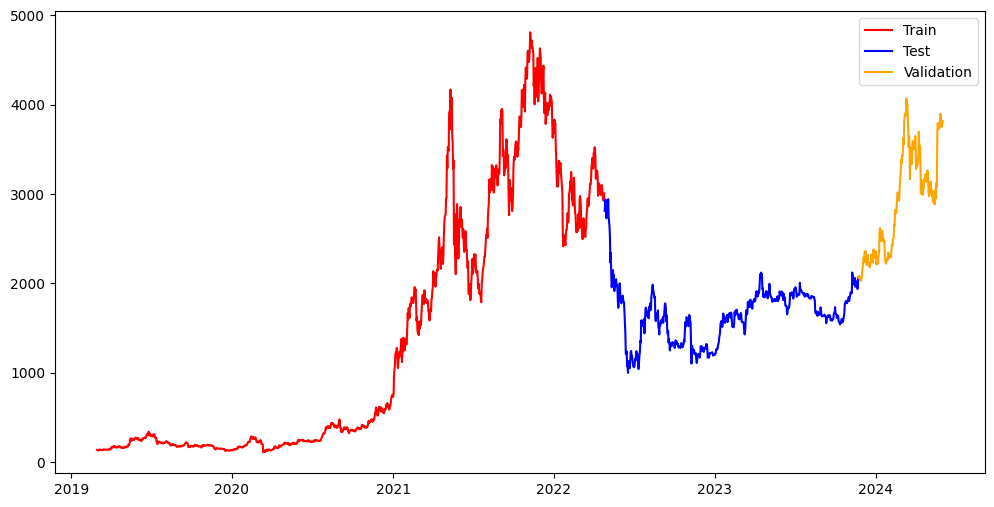

In [316]:
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(eth_df_train).index.to_list(), pd.DataFrame(eth_df_train['Price']), color='red', label='Train')
plt.plot(pd.DataFrame(eth_df_test).index.to_list(),pd.DataFrame(eth_df_test['Price']),color='blue' ,label ='Test')
plt.plot(pd.DataFrame(eth_df_val).index.to_list(),pd.DataFrame(eth_df_val['Price']),color ='orange', label ='Validation')
plt.legend()
plt.show()

In [320]:
scaler = MinMaxScaler(feature_range=(0, 1))
eth_df_train_scaled = scaler.fit_transform(eth_df_train)
eth_df_test_scaled = scaler.transform(eth_df_test)
eth_df_val_scaled = scaler.transform(eth_df_val)

eth_df_train_scaled = pd.DataFrame(eth_df_train_scaled, index=eth_df_train.index, columns=eth_df_train.columns)
eth_df_test_scaled = pd.DataFrame(eth_df_test_scaled, index=eth_df_test.index, columns=eth_df_test.columns)
eth_df_val_scaled = pd.DataFrame(eth_df_val_scaled,index =eth_df_val.index,columns=eth_df_val.columns)

In [321]:
X_train_scale = eth_df_train_scaled.drop(columns=['Price'])
y_train_scale = eth_df_train_scaled['Price']

X_test_scale  = eth_df_test_scaled.drop(columns=['Price'])
y_test_scale  = eth_df_test_scaled['Price']

X_val_scale = eth_df_val_scaled.drop(columns=['Price'])
y_val_scale = eth_df_val_scaled['Price']

In [326]:
print('X_train_scale shape: ',X_train_scale.shape)
print('y_train_scale shape: ',y_train_scale.shape)
print('\nX_test_scale shape: ',X_test_scale.shape)
print('y_test_scale shape: ',y_test_scale.shape)
print('\nX_val_scale shape: ',X_val_scale.shape)
print('y_val_scale shape: ',y_val_scale.shape)

X_train_scale shape:  (1152, 5)
y_train_scale shape:  (1152,)

X_test_scale shape:  (576, 5)
y_test_scale shape:  (576,)

X_val_scale shape:  (192, 5)
y_val_scale shape:  (192,)


###ARIMA

In [327]:
y_train

array([ 0.0109, -0.0426,  0.0353, ..., -0.0848, -0.0048, -0.0305])

In [328]:
stepwise_model = auto_arima(y_train, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=1,
                            start_P=0, seasonal=False,
                            d=None, D=0, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5204.378, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5206.338, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-5206.000, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5205.948, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5208.685, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5208.080, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-5208.046, Time=0.81 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5206.241, Time=0.84 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 3.048 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1536
Model:                        SARIMAX   Log Likelihood                2606.343
Date:                Thu, 13 Jun 2024   AIC                          -5208.685
Time:                       

In [354]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Sử dụng stepwise_model để dự đoán
y_pred_test_arima = stepwise_model.predict(n_periods=len(X_test_scale))

# Tính Mean Absolute Percentage Error (MAPE)
mape_test_arima = mean_absolute_percentage_error(y_test_scale, y_pred_test_arima)

# Tính Mean Absolute Error (MAE)
mae_test_arima = mean_absolute_error(y_test_scale, y_pred_test_arima)

# Tính Mean Squared Error (MSE)
mse_test_arima = mean_squared_error(y_test_scale, y_pred_test_arima)

# Tính Root Mean Squared Error (RMSE) bằng cách lấy căn bậc hai của MSE
rmse_test_arima = np.sqrt(mse_test_arima)

print("Test Set MAPE: ", mape_test_arima)
print("Test Set MAE: ", mae_test_arima)
print("Test Set RMSE: ", rmse_test_arima)


Test Set MAPE:  0.9925082320284128
Test Set MAE:  0.32590276317934813
Test Set RMSE:  0.3326266494698908


In [357]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

y_pred_val_arima = stepwise_model.predict(n_periods=len(X_val_scale))
mape_val_arima = mean_absolute_percentage_error(y_val_scale, y_pred_val_arima)
mae_val_arima = mean_absolute_error(y_val_scale, y_pred_val_arima)
mse_val_arima = mean_squared_error(y_val_scale, y_pred_val_arima)

print("Val Set MAPE: ", mape_val_arima)
print("Val Set MAE: ", mae_val_arima)
print("Val Set RMSE: ", rmse_val_arima)

Val Set MAPE:  0.9958435478158713
Val Set MAE:  0.5907696956522019
Val Set RMSE:  0.36414281839408885


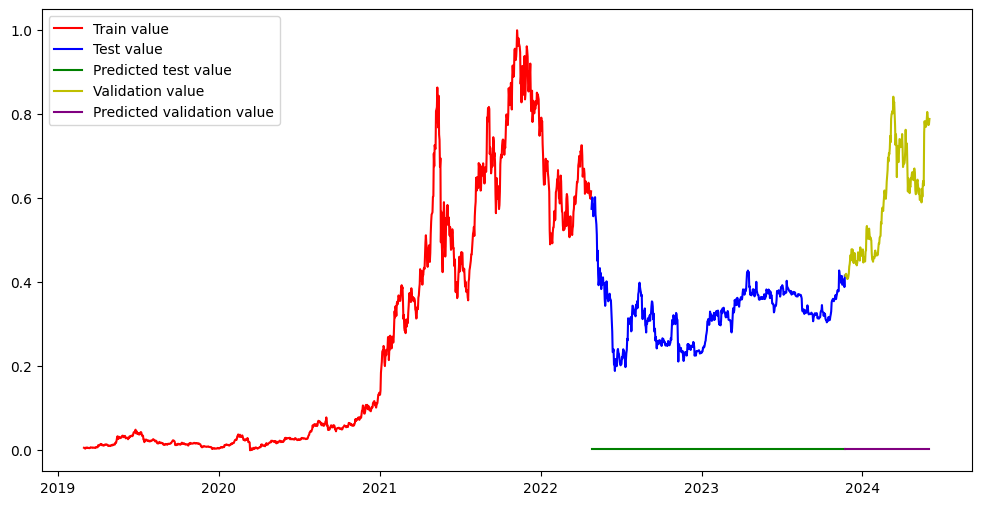

In [359]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_scale),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_scale), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_pred_test_arima), color='g', label='Predicted test value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(y_val_scale),color='y', label='Validation value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(y_pred_val_arima),color='purple', label='Predicted validation value')
plt.legend()
plt.show()

#RNN

In [ ]:
df1=eth_df.reset_index()['Price']

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

In [ ]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, ytest), epochs=100, batch_size=64, verbose=1)

In [ ]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input = val_data[-100:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
# 14. Vẽ hình
plt.plot(scaler.inverse_transform(train_data), label='Train Data')
plt.plot(range(train_size, train_size + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')
plt.plot(range(train_size + time_step, train_size + time_step + len(y_pred)), y_pred, label='Predicted Test Data')
plt.plot(range(len(df1), len(df1) + 30), scaler.inverse_transform(lst_output), label='Predicted Next 30 Days')

# Thêm val_data vào biểu đồ
plt.plot(range(train_size, train_size + len(val_data)), scaler.inverse_transform(val_data), label='Validation Data')

plt.legend()
plt.show()


In [ ]:
# 14. Vẽ hình
plt.plot(scaler.inverse_transform(train_data), label='Train Data')
plt.plot(range(train_size, train_size + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')
plt.plot(range(train_size + 100, train_size + 100 + len(y_pred)), y_pred, label='Predicted Test Data')
plt.plot(range(len(df1), len(df1) + 30), scaler.inverse_transform(lst_output), label='Predicted Next 30 Days')

plt.legend()
plt.show()

In [ ]:
# 13. Dự báo 60 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 60:  # Sửa số lần lặp từ 30 thành 60
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# 14. Vẽ hình
plt.plot(scaler.inverse_transform(train_data), label='Train Data')
plt.plot(range(train_size, train_size + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')
plt.plot(range(train_size + 100, train_size + 100 + len(y_pred)), y_pred, label='Predicted Test Data')
plt.plot(range(len(df1), len(df1) + 60), scaler.inverse_transform(lst_output), label='Predicted Next 60 Days')  # Sửa số ngày từ 30 thành 60
# Thêm val_data vào biểu đồ
plt.plot(range(train_size, train_size + len(val_data)), scaler.inverse_transform(val_data), label='Validation Data')

plt.legend()
plt.show()


In [ ]:
# 13. Dự báo 90 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 90:  # Sửa số lần lặp từ 30 thành 90
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# 14. Vẽ hình
plt.plot(scaler.inverse_transform(train_data), label='Train Data')
plt.plot(range(train_size, train_size + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')
plt.plot(range(train_size + 100, train_size + 100 + len(y_pred)), y_pred, label='Predicted Test Data')
plt.plot(range(len(df1), len(df1) + 90), scaler.inverse_transform(lst_output), label='Predicted Next 90 Days')  # Sửa số ngày từ 30 thành 90

plt.legend()
plt.show()

###LSTM

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

In [ ]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

In [ ]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE


valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
n_steps = 100
x_input = test_data[-n_steps:].reshape(1, -1)
x_input.shape

temp_input = list(x_input[0])

from numpy import array

lst_output = []
i = 0
while(i < 30):
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

In [ ]:

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
# 14. Vẽ hình
plt.plot(scaler.inverse_transform(train_data), label='Train Data')
plt.plot(range(train_size, train_size + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')
plt.plot(range(train_size + time_step, train_size + time_step + len(y_pred)), y_pred, label='Predicted Test Data')
plt.plot(range(len(df1), len(df1) + 30), scaler.inverse_transform(lst_output), label='Predicted Next 30 Days')

plt.legend()
plt.show()


In [ ]:
# 14. Vẽ hình
plt.plot(scaler.inverse_transform(train_data), label='Train Data')
plt.plot(range(train_size, train_size + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')
plt.plot(range(train_size + time_step, train_size + time_step + len(y_pred)), y_pred, label='Predicted Test Data')
plt.plot(range(len(df1), len(df1) + 30), scaler.inverse_transform(lst_output), label='Predicted Next 30 Days')

# Thêm val_data vào biểu đồ
plt.plot(range(train_size, train_size + len(val_data)), scaler.inverse_transform(val_data), label='Validation Data')

plt.legend()
plt.show()


In [ ]:
# 14. Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
# 13. Dự báo 60 ngày tiếp theo
n_steps = 100
x_input = test_data[-n_steps:].reshape(1, -1)
x_input.shape

temp_input = list(x_input[0])

from numpy import array

lst_output = []
i = 0
while(i < 60):  # Đổi từ 30 thành 60
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# 14. Vẽ hình
plt.plot(scaler.inverse_transform(train_data), label='Train Data')
plt.plot(range(train_size, train_size + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')
plt.plot(range(train_size + time_step, train_size + time_step + len(y_pred)), y_pred, label='Predicted Test Data')
plt.plot(range(len(df1), len(df1) + 60), scaler.inverse_transform(lst_output), label='Predicted Next 60 Days')

plt.legend()
plt.show()


In [ ]:
# 13. Dự báo 90 ngày tiếp theo
n_steps = 100
x_input = test_data[-n_steps:].reshape(1, -1)
x_input.shape

temp_input = list(x_input[0])

from numpy import array

lst_output = []
i = 0
while(i < 90):  # Đổi từ 60 thành 90
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# 14. Vẽ hình
plt.plot(scaler.inverse_transform(train_data), label='Train Data')
plt.plot(range(train_size, train_size + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')
plt.plot(range(train_size + time_step, train_size + time_step + len(y_pred)), y_pred, label='Predicted Test Data')
plt.plot(range(len(df1), len(df1) + 90), scaler.inverse_transform(lst_output), label='Predicted Next 90 Days')

plt.legend()
plt.show()

## Linear regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from scipy import stats

In [ ]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [ ]:
X_train_lr = X_train_scale
y_train_lr = y_train_scale

X_test_lr  = X_test_scale
y_test_lr = y_test_scale

X_val_lr = X_val_scale
y_val_lr = y_val_scale

In [ ]:
model_LR = LinearRegression()
model_LR.fit(X_train_scale, y_train_scale)

In [ ]:
pred_test_LR = model_LR.predict(X_test_scale)
pred_val_LR = model_LR.predict(X_val_lr)

In [ ]:
mape = mean_absolute_percentage_error(y_test_scale, pred_test_LR)
mae = mean_absolute_error(y_test_scale,pred_test_LR)
mse = mean_squared_error(y_test_scale, pred_test_LR)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_lr),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_lr), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_LR.reshape(-1)), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(y_val_lr),color='orange', label='Validation value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(pred_val_LR.reshape(-1)),color='purple', label='Predicted validation value')
plt.legend()
plt.show()

In [ ]:
model_filename = "model_LR.joblib"
joblib.dump(model_LR, model_filename)

In [ ]:
y

In [ ]:
X_test =X_test.sort_index(ascending=True)
X_test

In [ ]:
X_train

In [ ]:
test_data =X_test.join(y_test)
test_data =test_data.sort_index(ascending=True)
test_data

###ARIMA

In [ ]:
y_train

In [ ]:
stepwise_model = auto_arima(y_train, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=1,
                            start_P=0, seasonal=False,
                            d=None, D=0, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())

In [ ]:
pip install -U scikit-learn


In [ ]:
y_pred_test_arima = stepwise_model.predict(n_periods=len(X_test))
mape_test_arima = mean_absolute_percentage_error(y_test, y_pred_test_arima)
mae_test_arima = mean_absolute_error(y_test, y_pred_test_arima)
rmse_test_arima = root_mean_squared_error(y_test, y_pred_test_arima)

print("Test Set MAPE: ", mape_test_arima)
print("Test Set MAE: ", mae_test_arima)
print("Test Set RMSE: ", rmse_test_arima)

y_pred_val_arima = stepwise_model.predict(n_periods=len(X_val))
mape_val_arima = mean_absolute_percentage_error(yval, y_pred_val_arima)
mae_val_arima = mean_absolute_error(yval, y_pred_val_arima)
rmse_val_arima = root_mean_squared_error(yval, y_pred_val_arima)

print("Val Set MAPE: ", mape_val_arima)
print("Val Set MAE: ", mae_val_arima)
print("Val Set RMSE: ", rmse_val_arima)

In [ ]:
# Đảm bảo rằng n_periods bằng với kích thước của y_test
y_pred_test_arima = stepwise_model.predict(n_periods=len(y_test))

# Tính toán các chỉ số đánh giá mô hình
mape_test_arima = mean_absolute_percentage_error(y_test, y_pred_test_arima)
mae_test_arima = mean_absolute_error(y_test, y_pred_test_arima)
# Sử dụng mean_squared_error với squared=False để tính RMSE
rmse_test_arima = mean_squared_error(y_test, y_pred_test_arima, squared=False)

print("Test Set MAPE: ", mape_test_arima)
print("Test Set MAE: ", mae_test_arima)
print("Test Set RMSE: ", rmse_test_arima)

# Đảm bảo rằng n_periods bằng với kích thước của y_val
y_pred_val_arima = stepwise_model.predict(n_periods=len(yval))

# Tính toán các chỉ số đánh giá mô hình cho validation set
mape_val_arima = mean_absolute_percentage_error(yval, y_pred_val_arima)
mae_val_arima = mean_absolute_error(yval, y_pred_val_arima)
# Sử dụng mean_squared_error với squared=False để tính RMSE
rmse_val_arima = mean_squared_error(yval, y_pred_val_arima, squared=False)

print("Val Set MAPE: ", mape_val_arima)
print("Val Set MAE: ", mae_val_arima)
print("Val Set RMSE: ", rmse_val_arima)


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df_scaled = scaler.fit_transform(eth_df_train)
test_df_scaled = scaler.transform(eth_df_test)
val_df_scaled = scaler.transform(eth_df_val)

train_df_scaled = pd.DataFrame(train_df_scaled, index=eth_df_train.index, columns=eth_df_train.columns)
test_df_scaled = pd.DataFrame(test_df_scaled, index=eth_df_test.index, columns=eth_df_test.columns)
val_df_scaled = pd.DataFrame(val_df_scaled,index =eth_df_val.index,columns=eth_df_val.columns)

In [ ]:
print('train_df_scaled shape: ',train_df_scaled.shape)
print('test_df_scaled shape: ',test_df_scaled.shape)
print('val_df_scaled shape: ',val_df_scaled.shape)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train).index.to_list(),pd.DataFrame(y_train),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_pred_test_arima), color='g', label='Predicted test value')
plt.plot(pd.DataFrame(yval).index.to_list(),pd.DataFrame(yval),color='y', label='Validation value')
plt.plot(pd.DataFrame(yval).index.to_list(),pd.DataFrame(y_pred_val_arima),color='purple', label='Predicted validation value')
plt.legend()
plt.show()

###GRU

In [ ]:
from keras.layers import Dense, GRU

In [ ]:
df1=eth_df.reset_index()['Price']

In [ ]:
X_train_GRU = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_train_GRU = y_train  # Nếu y_train đã là một numpy.ndarray

X_test_GRU = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_test_GRU = y_test

X_val_GRU = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_val_GRU = yval


In [ ]:
def build_GRU_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(GRU(neurons,  input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
model_GRU = build_GRU_model(
    (X_train_GRU.shape[1], X_train_GRU.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [ ]:
history = model_GRU.fit(
    X_train_GRU, y_train_GRU, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [ ]:
# Xây dựng mô hình GRU
model_GRU = Sequential()
model_GRU.add(GRU(50, return_sequences=True, input_shape=(1, X_train_GRU.shape[2])))
model_GRU.add(GRU(50, return_sequences=False))
model_GRU.add(Dense(25))
model_GRU.add(Dense(1))

# Compile mô hình
model_GRU.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
history_GRU = model_GRU.fit(X_train_GRU, y_train_GRU, validation_data=(X_val_GRU, y_val_GRU), epochs=100, batch_size=64, verbose=1)

In [ ]:
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
import pandas as pd

def create_dataset(data, time_step):
  """
  Hàm này tạo bộ dữ liệu chuỗi thời gian từ một DataFrame Pandas.

  Args:
      data: Một DataFrame Pandas chứa dữ liệu.
      time_step: Số bước thời gian để bao gồm trong mỗi mẫu.

  Returns:
      X: Một DataFrame Pandas chứa các tính năng (dữ liệu dịch chuyển thời gian).
      y: Một Series Pandas chứa các giá trị mục tiêu.
  """

  X, y = [], []
  for i in range(len(data) - time_step + 1):  # Chỉnh sửa vòng lặp để tránh lỗi
    X.append(data.iloc[i:i + time_step])
    y.append(data.iloc[i + time_step - 1])  # Chỉnh sửa vị trí lấy giá trị mục tiêu

  return pd.DataFrame(X), pd.Series(y)

# Dữ liệu mẫu (thay thế bằng dữ liệu thực tế của bạn)
data = pd.Series(range(100))  # Tạo một Series mẫu

# Tạo bộ dữ liệu chuỗi thời gian với time_step = 49
time_step = 49

# ... (phần còn lại của mã của bạn để chia dữ liệu và tạo bộ dữ liệu)


In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 49
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features]
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
n_steps = 100
x_input = test_data[-n_steps:].reshape(1, -1)
x_input.shape

temp_input = list(x_input[0])

from numpy import array

lst_output = []
i = 0
while(i < 30):
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

###Draft

In [ ]:
# Format "Date" column
eth_df['Date'] = pd.to_datetime(eth_df['Date'], format='%m/%d/%Y')

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(eth_df['Date'], bins=20, kde=True)
plt.title('Histogram of Ethereum Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [ ]:
new_df=eth_df.drop[['Price', 'Change %']]
X =new_df.drop(['Price'],axis = 1)
y = new_df['Change %']

In [ ]:
print('x_scale.shape: ',x_scale.shape)
print('y_scale.shape: ',y_scale.shape)

In [ ]:
x_train, y_train, x_test, y_test = train_test_split(x_scale, y_scale, 0.2, 10)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ',y_train.shape)
print('X_test.shape: ',X_test.shape)
print('y_test.shape: ',y_test.shape)